In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities.
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [31]:
import pytesseract
import shutil
import os
import gdown

import random
try:
 from PIL import Image
except ImportError:
 import Image

import numpy as np
import cv2
import pickle

In [4]:
import glob
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
from math import sqrt
from statistics import mean
import os, json, cv2, random, pickle, glob

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.visualizer import Visualizer

from detectron2.utils.visualizer import ColorMode
from google.colab.patches import cv2_imshow

In [5]:
def get_dict_list(dir_name: str):
  file_list = glob.glob(os.path.join(dir_name, '*.json'))
  dict_list = []
  for file in file_list:
    with open(file) as f:
      json_file = json.load(f)
      file_name = json_file['file_name'].split("\\")[-1]
      json_file['file_name'] = os.path.join(dir_name, file_name)
      dict_list.append(json_file)
  return dict_list

In [ ]:
# https://drive.google.com/file/d/1bKT7PXmwc144slW_w1Yv8PYq-5MS0jpe/view?usp=share_link
gdown.download(
   f"https://drive.google.com/uc?export=download&confirm=pbef&id=1bKT7PXmwc144slW_w1Yv8PYq-5MS0jpe",
   None
)
!unzip /content/data_val_hard.zip > /dev/null

In [ ]:
# Загружаю мою обученную модель

output = None
gdown.download(
    f"https://drive.google.com/uc?export=download&confirm=pbef&id=1-HRd6thrXGm-TD7l8nXfb8u2Wyj1vmQu",
    output
)

In [10]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.DEVICE = "cpu"
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 # edge type 1, edge type 2 and node

# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = "model_super_final.pth"  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[12/25 11:45:20 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from model_super_final.pth ...


In [11]:
def structure_detected_info(outputs):
  classes = outputs["instances"].pred_classes
  bboxes = outputs["instances"].pred_boxes
  scores = outputs["instances"].scores

  node_bboxes = [[int(val) for val in list(bboxes[index][0])[0]]
                 for index in range(len(bboxes)) if classes[index] == 0]
  edge_bboxes = [[int(val) for val in list(bboxes[index][0])[0]]
                 for index in range(len(bboxes)) if classes[index] != 0]
  node_scores = [float(scores[index]) for index in range(len(bboxes)) if classes[index] == 0]
  edge_scores = [float(scores[index]) for index in range(len(bboxes)) if classes[index] != 0]
  edge_types = [int(classes[index]) for index in range(len(bboxes)) if classes[index] != 0]
  nodes = [{"bbox": node_bboxes[i],
            "score": node_scores[i]} for i in range(len(node_bboxes))]
  edges = [{"bbox": edge_bboxes[i],
            "score": edge_scores[i],
            "type": edge_types[i]} for i in range(len(edge_bboxes))]
  return nodes, edges

In [12]:
def correct_names(names):
  corrected_names = []
  for name in names:
    name = name.upper()
    name = [val for val in name if val.isalpha() or val.isnumeric()]
  
    # TODO: можно сделать замены цифр и букв в соответствии с самыми частыми ошибками 
    name = ''.join(name)
    corrected_names.append(name)
  return corrected_names

In [13]:
def recognize_node_names(image, nodes):
  names = []
  for node in nodes:
      x1, y1, x2, y2 = node['bbox']
      node['center'] = {"x": int(x1 + abs(x2 - x1)/2),
                        "y": int(y1 + abs(y2 - y1)/2)}
      cropped = crop_by_bbox(image, node['bbox'])
  
      # Apply OCR on the cropped image
      custom_config = r'--oem 3 --psm 6 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789 tessedit_char_blacklist=éo'
      text = pytesseract.image_to_string(cropped, config=custom_config)
      names.append(text.split(sep="\n")[0])

      names = correct_names(names)
 
  return names        

In [14]:
def crop_by_bbox(image, bbox):
  x1, y1, x2, y2 = bbox
  im2 = image.copy()
  shift_x = int(abs(x2 - x1)*0.25)
  shift_y = int(abs(y2 - y1)*0.25)
  cropped = im2[y1 + shift_y: y2 - shift_y,
                x1 + shift_x: x2 - shift_x]
  return cropped

In [15]:
def find_edge_direction(image, edges):
  ends = []
  for edge in edges:
    cropped = crop_by_bbox(image, edge['bbox'])
    cropped_with_d1 = cropped.copy()
    cropped_with_d2 = cropped.copy()
    x = len(cropped[0])
    y = len(cropped)

    # 1st diagonal
    intensity_d1 = 0
    k_d1 = y/x
    # 2nd diagonal
    intensity_d2 = 0
    k_d2 = - y/x
    for x_coord in range(0, x):
      # сами значения на диагоналях
      y_coord_d1 = int(k_d1*x_coord)
      y_coord_d2 = int(k_d2*x_coord + y)

      # раздвигаем
      y_coord_d1_upper = max(0, y_coord_d1 - 7)
      y_coord_d1_lower = min(y - 1, y_coord_d1 + 7)
      y_coord_d2_upper = max(0, y_coord_d2 - 7)
      y_coord_d2_lower = min(y - 1, y_coord_d2 + 7)

      cropped_with_d1[y_coord_d1_upper][x_coord] = (255, 0, 0)
      cropped_with_d1[y_coord_d1_lower][x_coord] = (255, 0, 0)

      cropped_with_d2[y_coord_d2_upper][x_coord] = (255, 0, 0)
      cropped_with_d2[y_coord_d2_lower][x_coord] = (255, 0, 0)

      # теперь перебираем точки внутри этого среза полосы
      # вокруг каждой диагонали
      for y_exp in range(y_coord_d1_upper, y_coord_d1_lower):
        intensity_d1 += sum(cropped[y_exp][x_coord])

      for y_exp in range(y_coord_d2_upper, y_coord_d2_lower):
        intensity_d2 += sum(cropped[y_exp][x_coord])
    # мы на второй диагонали (правый верхний - левый нижний)
    if intensity_d1 > intensity_d2: # True - если меньше черных
      x1, y1, x2, y2 = edge['bbox']
      ends.append([x1, y2, x2, y1])
    # мы на первой диагонали (левый верхний - правый нижний)
    else:
      ends.append(edge['bbox'])
  return ends

In [16]:
def find_connected_nodes(detected_res):
  connected_nodes = []
  # центр какой ноды ближе всех
  for edge in detected_res["edges"]:
    x1, y1, x2, y2 = edge["ends"]
    #print("ends", edge["ends"])
    min_end1_dist, min_end2_dist = 10000, 10000
    end1_node, end2_node = None, None

    for node_name, info in detected_res["nodes"].items():
      x = info["center"]["x"]
      y = info["center"]["y"]
      end1_dist = sqrt(pow(x1 - x, 2) + pow(y1 - y, 2))
      if end1_dist < min_end1_dist:
        min_end1_dist = end1_dist
        end1_node = node_name

      end2_dist = sqrt(pow(x2 - x, 2) + pow(y2 - y, 2))
      if end2_dist < min_end2_dist:
        min_end2_dist = end2_dist
        end2_node = node_name
    connected_nodes.append((end1_node, end2_node))
  return connected_nodes


In [17]:
def detect_info(path_to_graph_picture, visualize=False):
  im = cv2.imread(path_to_graph_picture)
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1], scale=0.5)
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  img_name = d['file_name'].split('\\')[-1]
  if visualize:
    cv2_imshow(out.get_image()[:, :, ::-1])
    cv2_imshow(im)

  nodes, edges = structure_detected_info(outputs)
  detected_info = {"nodes": nodes, "edges": edges}
    
  names = recognize_node_names(im, nodes)
  nodes_dict = {}
  for index in range(len(nodes)):
    nodes_dict[names[index]] = nodes[index]
  detected_info["nodes"] = nodes_dict
  
  ends = find_edge_direction(im, edges)
  for index in range(len(edges)):
    edge = edges[index]
    edge["ends"] = ends[index]

  
  connected_nodes = find_connected_nodes(detected_info)
  for index in range(len(edges)):
    edge = edges[index]
    edge["nodes"] = connected_nodes[index]

  return detected_info

In [19]:
def construct_graph_from_detected_info(info):
  # nodes - dict of dicts: {'name': {'bbox': , 'score':, 'center':}}
  # edges - list of dicts: {'bbox', 'score', 'type', 'ends', 'nodes'}

  # Хотим словарь - {'a': {'b': {'weight': '1', 'type': 0}}, ...}
  # Если хоть раз распознал двойное между вершинами, то это оно.

  # учту так и найденные вершины, ребра которых не распознались
  graph_dict = {name: {} for name in info["nodes"].keys()}
  for edge in info["edges"]:
    node_1, node_2 = edge["nodes"]
    # если уже эти вершины связаны каким-то ребром
    if node_2 in graph_dict[node_1].keys():
      # пришло одинарное ребро поверх записанного и записанного уже двойное
      if edge["type"] == 1 and graph_dict[node_1][node_2]["type"] == 2:
        # в этом случае не хотим никак переписывать, двойное перевешивает
        continue
    # в оставшихся случаях надо записывать
    graph_dict[node_1][node_2] = {"weight": 1,
                                    "type": edge["type"],
                                    "score": edge["score"]}
    graph_dict[node_2][node_1] = {"weight": 1,
                                   "type": edge["type"],
                                   "score": edge["score"]} 
  return graph_dict

In [28]:
def assess_recognition(graph_dict, true_graph_dict, verbose=False):
  node_recognition_score = 0
  edge_recognition_score = 0
  edge_type_recognition_score = 0

  true_node_num = len(true_graph_dict.keys())
  true_edge_num = sum([len(true_graph_dict[node]) for node in true_graph_dict.keys()])

  for node, adj_nodes in true_graph_dict.items():
    if node in graph_dict.keys():
      node_recognition_score += 1
      for adj_node, adj_node_info in adj_nodes.items():
        if adj_node in graph_dict[node].keys():
          edge_recognition_score += 1
          if adj_node_info["type"] == graph_dict[node][adj_node]["type"]:
            edge_type_recognition_score += 1
  if verbose:
    print("Nodes recognized: ", node_recognition_score, " out of ", true_node_num)
    print("Edges recognized: ", edge_recognition_score, " out of ", true_edge_num)
    print("Typed correctly: ", edge_type_recognition_score, " out of ", edge_recognition_score)

  node_recognition_score = node_recognition_score/true_node_num
  if edge_recognition_score:
   edge_type_recognition_score = edge_type_recognition_score/edge_recognition_score
  edge_recognition_score = edge_recognition_score/true_edge_num
  

  return {"node_recognition_score": node_recognition_score, 
          "edge_recognition_score": edge_recognition_score, 
          "edge_type_recognition_score": edge_type_recognition_score,
          "overall_score": mean([node_recognition_score,
                                edge_recognition_score,
                                edge_type_recognition_score])}
    

In [22]:
def get_true_graph_dict(img_filename):
  true_dict_file = img_filename.split(sep=".")[0] + "_src_dict.pickle"
  with open(true_dict_file, "rb") as f:
    graph = pickle.load(f)
  return graph

In [39]:
def picture_to_adj_list(img_filename):
  info = detect_info(img_filename) # это детектрон
  graph_dict = construct_graph_from_detected_info(info) # это детерминированная сборка графа
  return graph_dict

In [29]:
dataset_dicts = get_dict_list("/content/data_val_hard")

overall_scores = []
node_recognition_scores = []
edge_recognition_scores = []
edge_type_recognition_scores = []

for d in dataset_dicts: 
  graph_dict = picture_to_adj_list(d["file_name"])
  true_graph_dict = get_true_graph_dict(d["file_name"])
  scores = assess_recognition(graph_dict, true_graph_dict)
  
  overall_scores.append(scores["overall_score"])
  node_recognition_scores.append(scores["node_recognition_score"])
  edge_recognition_scores.append(scores["edge_recognition_score"])
  edge_type_recognition_scores.append(scores["edge_type_recognition_score"])
print("mean(overall_scores)", mean(overall_scores))
print("mean(node_recognition_scores)", mean(node_recognition_scores))
print("mean(edge_recognition_scores)", mean(edge_recognition_scores))
print("mean(edge_type_recognition_scores)", mean(edge_type_recognition_scores))

mean(overall_scores) 0.5653315360762169
mean(node_recognition_scores) 0.5749437323905409
mean(edge_recognition_scores) 0.2841714432139964
mean(edge_type_recognition_scores) 0.8368794326241135


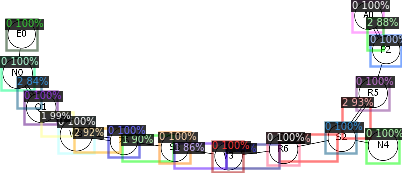

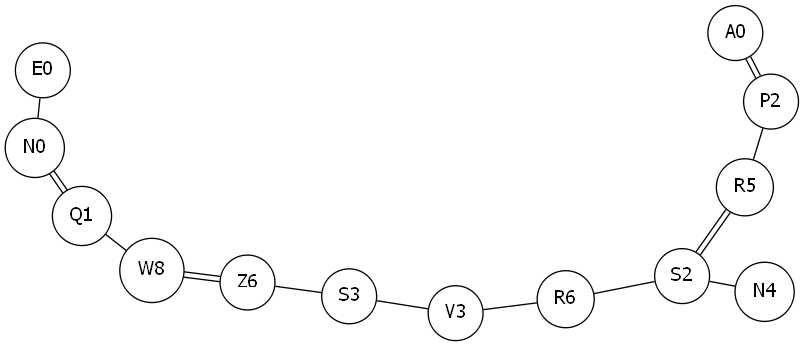

Nodes recognized:  8  out of  13
Edges recognized:  5  out of  13
Typed correctly:  5  out of  5


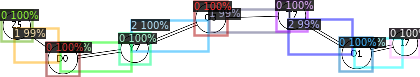

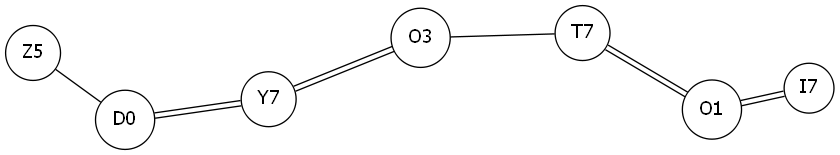

Nodes recognized:  3  out of  7
Edges recognized:  0  out of  7
Typed correctly:  0  out of  0


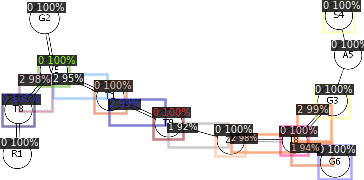

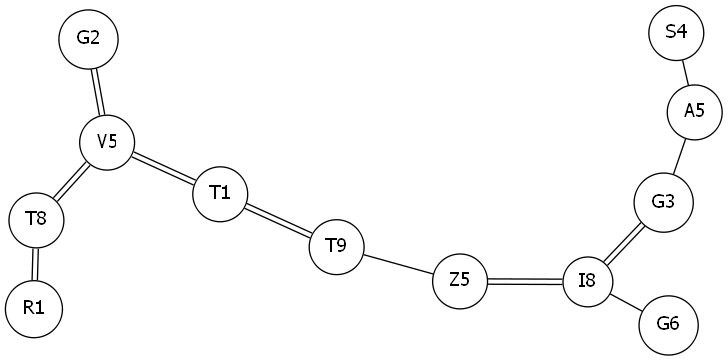

Nodes recognized:  8  out of  12
Edges recognized:  4  out of  12
Typed correctly:  4  out of  4


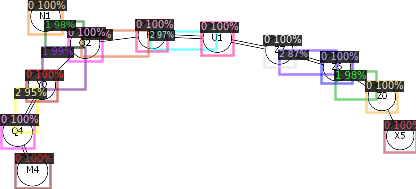

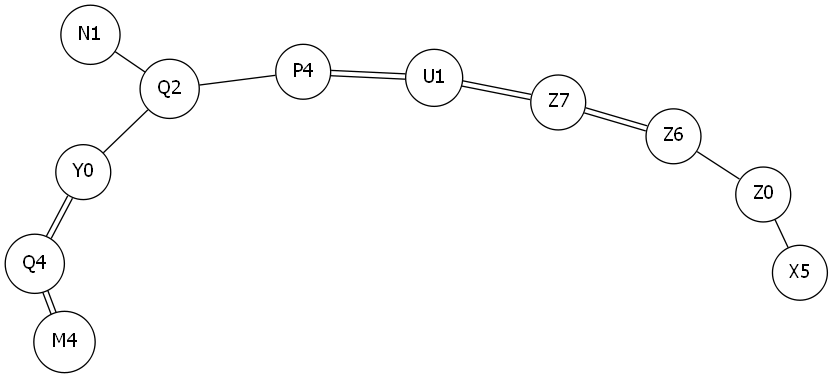

Nodes recognized:  4  out of  11
Edges recognized:  1  out of  11
Typed correctly:  1  out of  1


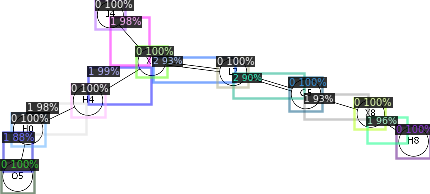

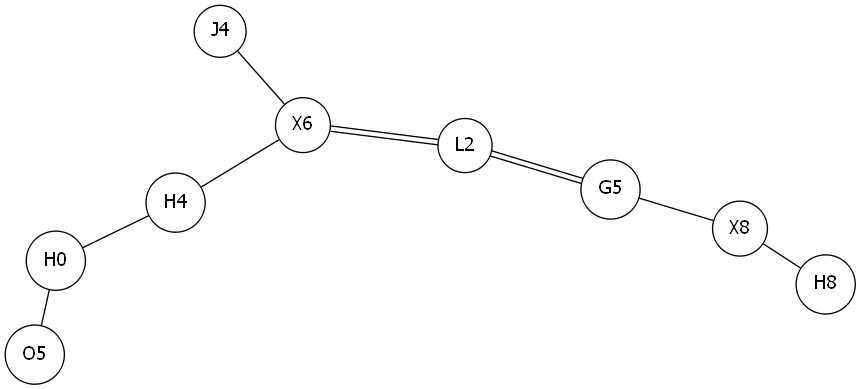

Nodes recognized:  5  out of  9
Edges recognized:  3  out of  9
Typed correctly:  3  out of  3


In [38]:
dataset_dicts = get_dict_list("/content/data_val_hard")

for d in random.sample(dataset_dicts, 5): 
  graph_dict = picture_to_adj_list(d["file_name"])
  true_graph_dict = get_true_graph_dict(d["file_name"])
  scores = assess_recognition(graph_dict, true_graph_dict, verbose=True)